<h1 style="padding-top: 25px;padding-bottom: 25px;text-align: left; padding-left: 10px; background-color: #DDDDDD; 
    color: black;"> <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science </h1>

## Case Study: Hunting for Flavors
## PARTS 1- 4: Problem Statement, Obtaining Data, Cleaning Data, Exploring Data

**Harvard University**<br/>
**Fall 2020**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Tanner<br/>
<hr style='height:2px'>

In [1]:
## RUN THIS CELL TO GET THE RIGHT FORMATTING 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2020-CS109A/master/themes/static/css/cs109.css").text
HTML(styles)

In [2]:
# import the necessary libraries
import re
import requests
import random
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import numpy as np
from time import sleep
from bs4 import BeautifulSoup

# global properties
data_dir = "data/" # where to save data
num_search_pages = 50 # how many search pages to cull through

# NOTE:
# if you haven't yet downloaded the data, this should be set to True
download_data = False

## Disclaimer

Alcohol is drug. There are state and federal laws that govern the sale, distribution, and consumption of such. In the United States, those who consume alcohol must be at least 21 years of age. In no way am I, or anyone else at IACS or Harvard at large, promoting or encouraging the usage of alcohol. My intention is not to celebrate it. Anyone who chooses to consume alcohol should be of legal age and should do so responsibly. Abusing alcohol has serious, grave effects.

The point of this exercise is purely pedagogical, and it illustrates the wide range of tasks to which one can apply data science and machine learning. That is, I am focusing on a particular interest and demonstrating how it can be used to answer questions that one may be interested in for one's own personal life. You could easily imagine this being used in professional settings, too.

### Learning Objectives
Help see the big picture process of conducting a project, and to illustrate some of the nuanced details and common pitfalls.

## 1. Problem Overview 

Whiskey is a type of alcohol, and there are many different types of whiskey, including **bourbon,** which will be the focus of this project. 

I am interested in determining:

1. Are there certain attributes of bourbons that are predictive of good (i.e., highly rated by users) bourbons?
    - Find hidden gems (i.e., should be good but current reviews are absent or unsupportive of such)
	- Find over-hyped whiskeys (i.e., the reviews seem high but the attributes aren't indicative)
	- Are there significant results if we target experts' ratings instead of average customer ratings?

2. Are there certain attributes of bourbons that are predictive of expensive bourbons?
    - Find under-priced whiskeys
    - Find over-priced whiskeys

3. Which bourbons are more similar to each other?
    - Which attributes are important for determining similarness? (e.g., does price play a role?)

## 2. Obtaining Data

We need a website that has a bunch of whiskey data. `Distiller.com` seems to be the most authoritative and comprehensive site.

Using `distiller.com` as our source, I don't see a way to display a list of all of their bourbons. But, if you search for the keyword `bourbon`, over 2,000 search results appear, each with a link to the particular whiskey. After manual inspection, these in fact are bourbons, but a few are not and merely have some association with bourbon (e.g., non-bourbon whiskeys that were casked in old bourbon barrels).

Let's crawl the search results pages to create a set of all candidate bourbons (i.e., `whiskey_urls`)! Then, using this set, let's download each page. Note, we use a `set()` instead of a list, in case there are duplicates.

<div class='exercise'><b>Fetching list of webpages via Requests</b></div>

In [3]:
whiskey_urls = set()

if download_data:

    # we define this for convenience, as every state's url begins with this prefix
    base_url = 'https://distiller.com/search?term=bourbon'
    
    # visits each search result page
    for page_num in range(1, num_search_pages):
        cur_page = requests.get('https://distiller.com/search?page=' + str(page_num) + '&term=bourbon')

        # uses BeautifulSoup to extract all links to whiskeys
        bs_page = BeautifulSoup(cur_page.content, "html.parser")
        for link in bs_page.findAll('a', attrs={'href': re.compile("^/spirits/")}):
            whiskey_urls.add(link.get('href'))

        sleep(1)
    
    # saves each URL to disk, so that we don't have to crawl the search results again
    f = open("whiskey_urls.txt", "w")
    for url in whiskey_urls:
        f.write(url + "\n")
    f.close()
    
    # fetches each page and saves it to the hard drive
    for url in whiskey_urls:
        cur_page = requests.get('https://distiller.com' + url).content

        # writes file
        f = open(data_dir + url[9:], 'wb')
        f.write(cur_page)
        f.close()

        # sleeps between 1-3 seconds, in case the site tries to detect crawling
        sleep(random.randint(1,3))
else: 
    
    # if the files have already been saved to disk
    # then you can just load them here, instead of crawling again
    with open('whiskey_urls.txt') as f:
        whiskey_urls = set(line.strip() for line in f)

We now have a list of all whiskey urls, in `whiskey_urls`, along with the actual page downloaded to our hard drive. We downloaded them to the hard drive for convenience, so that in the future, we don't have to spend the 2 hours crawling all pages again.

Let's now load each of these pages!

In [4]:
whiskeys = {}

# loads whiskey webpage
for i, url in enumerate(whiskey_urls):

    filename = data_dir + url[9:]
    file_contents = open(filename, 'r').read()
    
    # instantiates a new BeautifulSoup object
    soup = BeautifulSoup(file_contents, "html.parser")
    
    # extracts details about the whiskey
    name = soup.find('h1', attrs={'class': re.compile("secondary-headline name")}).text.strip()
    location = soup.find('h2', attrs={'class': "ultra-mini-headline location middleweight"}).text.strip()

    soup.find('div', attrs={'class': "spirit-badge"})

    badge = ""
    if soup.find('div', attrs={'class': "spirit-badge"}) != None:
        badge = soup.find('div', attrs={'class': "spirit-badge"}).text.strip()
        
    num_ratings = 0
    rating = "N/A"
    if soup.find('span', attrs={'itemprop': "ratingCount"}) != None:
        num_ratings = int(soup.find('span', attrs={'itemprop': "ratingCount"}).text.strip())
        rating = float(soup.find('span', attrs={'itemprop': "ratingValue"}).text.strip())
    
    age = soup.find('li', attrs={'class': "detail age"}).find('div', attrs='value').text.strip()
    price = int(re.findall("cost-(\d)", str(soup.find('div', attrs={'class': re.compile("spirit-cost")})))[0])
    abv = ""
    
    if soup.find('li', attrs={'class': "detail abv"}).find('div', attrs='value').text != "":
        abv = float(soup.find('li', attrs={'class': "detail abv"}).find('div', attrs='value').text)
    
    whiskey_type = soup.find('li', attrs={'class': "detail whiskey-style"}).div.text
    cask_type = ""
    if soup.find('li', attrs={'class': "detail cask-type"}) != None:
        cask_type = soup.find('li', attrs={'class': "detail cask-type"}).find('div', attrs='value').text.strip()
    
    review = ""
    expert = ""
    score = ""
    flavor_summary = ""
    flavor_profile = []
    
    # check if an expert reviewed it
    if soup.find('p', attrs={'itemprop': "reviewBody"}) != None:
        review = soup.find('p', attrs={'itemprop': "reviewBody"}).text.replace("\"","").strip()
    
        expert = soup.find('div', attrs={'class': 'meet-experts'}).a.text.strip()
        score = int(soup.find('div', attrs={'class': "distiller-score"}).span.text.strip())
        flavor_summary = soup.find('h3', attrs={'class': "secondary-headline flavors middleweight"}).text.strip()
    
        # extracts flavor profile
        flavor_profile = eval(soup.find('canvas').attrs['data-flavors'])
    
    cur_whiskey = [name, whiskey_type, cask_type, location, age, abv, price, badge, num_ratings, \
        rating, flavor_summary, expert, score]

    if flavor_profile:
        cur_whiskey.extend(list(flavor_profile.values()))
    else:
        cur_whiskey.extend(np.zeros(14))
        
    cur_whiskey.append(review)
    whiskeys[i] = cur_whiskey

    df = pd.DataFrame.from_dict(whiskeys, orient='index', \
        columns=['Name', 'Type', 'Cask', 'Location', 'Age', 'ABV %', 'Price', 'Badge',\
                 '# Ratings', "Customers' Rating", 'Flavor Summary', 'Expert', 'Expert Score',\
                 'Smoky', 'Peaty', 'Spicy', 'Herbal', 'Oily', 'Full-bodied', 'Rich',\
                 'Sweet', 'Briny', 'Salty', 'Vanilla', 'Tart', 'Fruity', 'Floral', 'Review'])

## 3. Data Sanity Check / Cleaning

What do our features look like? Are any features wonky, inconsistent, useless, or missing values?

<div class='exercise'><b>Let's use only the whiskeys that have been reviewed by experts</b>
</div>

In [5]:
pd.set_option('display.max_columns', None)
df2 = df.loc[(df['Expert'] != "")]
print(len(df2))

710


In [6]:
df2['Type'].value_counts()

Bourbon                          586
Single Malt                       27
Blended American Whiskey          14
Aged Rum                          12
Peated Single Malt                11
Other Whiskey                     11
Flavored Whiskey                   5
Gold Rum                           4
Rhum Agricole Vieux                4
Tequila Reposado                   4
Blended                            3
American Single Malt               3
Spiced Rum                         3
Tequila Añejo                      3
Flavored Rum                       2
Barrel-Aged Gin                    2
Rye                                2
Canadian                           2
Dark Rum                           2
Cachaça                            2
Other Brandy                       1
Rhum Agricole Éléve Sous Bois      1
Rhum Agricole Blanc                1
Dairy/Egg Liqueurs                 1
Silver Rum                         1
White                              1
Old Tom Gin                        1
O

<div class='exercise'><b>Let's only use the bourbons.</b> We have 586 bourbons, which is my primary focus. This isn't tons, but the non-bourbons will likely add noise, as they are different alcohols.
</div>

In [7]:
pd.set_option('display.max_rows', None)
df2 = df2.loc[(df['Type'] == "Bourbon")]

<div class='exercise'><b>Let's inspect the data types</b>
</div>

In [8]:
df2.dtypes

Name                  object
Type                  object
Cask                  object
Location              object
Age                   object
ABV %                 object
Price                  int64
Badge                 object
# Ratings              int64
Customers' Rating     object
Flavor Summary        object
Expert                object
Expert Score          object
Smoky                float64
Peaty                float64
Spicy                float64
Herbal               float64
Oily                 float64
Full-bodied          float64
Rich                 float64
Sweet                float64
Briny                float64
Salty                float64
Vanilla              float64
Tart                 float64
Fruity               float64
Floral               float64
Review                object
dtype: object

<div class='exercise'><b>"Customers' Rating"</b> feature should be a Float. Let's fix it.
</div>

In [9]:
df2.loc[df2['Customers\' Rating'] == "N/A"]

,Name,Type,Cask,Location,Age,ABV %,Price,Badge,# Ratings,Customers' Rating,Flavor Summary,Expert,Expert Score,Smoky,Peaty,Spicy,Herbal,Oily,Full-bodied,Rich,Sweet,Briny,Salty,Vanilla,Tart,Fruity,Floral,Review
1765,Tacoma New West Bourbon,Bourbon,"new, charred American oak","Heritage Distilling Co. // Washington, USA",NAS,46,2,,0,N/A,Vanilla & Sweet,Brock Schulte,78,0.0,0.0,30.0,40.0,0.0,40.0,30.0,80.0,20.0,20.0,100.0,30.0,60.0,50.0,"Nose is full of sweet corn, fresh caramel, and..."


In [10]:
# there still exists 1 whiskey that has no Customer Rating, so let's remove it
df2 = df2.loc[df2['Customers\' Rating'] != "N/A"]
df2 = df2.astype({'Customers\' Rating' : 'float64'})

<div class='exercise'><b>"Age"</b> feature should represent years. Let's fix it.
</div>

In [11]:
# we can keep the 'Age' feature for now but be mindful
# that it's missing for nearly half of the whiskeys
len(df2.loc[(df2['Age'] == 'NAS') | (df2['Age'] == 'nas') | (df2['Age'] == '')])

378

In [12]:
# let's replace all missing values with a reasonable value.
# for now, let's use 0 as a placeholder so that we can later swap it out.
df2['Age'] = df2['Age'].replace(['NAS', 'nas', 'N/A',''],'0')

In [13]:
# remove the 'Years' part of the text
df2['Age'].replace(to_replace =' [yY]ear[sS]*', value = '', regex = True) 

0                     0
4                     0
12        7 y, 2 m,16 d
21                    0
22                    0
26                   17
27                    0
28                    0
38                    6
40                   17
49                    0
52                    0
53                    0
59                    0
60                   10
65                    0
67                    0
75                    0
81                    0
85                    0
97                   15
98                   12
99                    0
113                   0
115                   0
118                  12
119     6 YR 3 MO 10 DY
126                   0
127                   0
128                   0
129                   0
130                   0
136                   0
140                  22
143                   0
147                   0
148                   0
149                   3
151                   0
153                   0
154     6 YR 4 MO 12 DY
159             

In [14]:
# manually cleaning up values that otherwise would be a bit impossible to automatically clean-up
df2['Age'] = df2['Age'].replace(to_replace ='6.*', value = '6', regex = True)
df2['Age'] = df2['Age'].replace(to_replace ='(\d+) [Yy].*', value = '\\1', regex = True)
df2['Age'] = df2['Age'].replace(to_replace ='4 [Mm]onths', value = '4', regex = True)
df2['Age'] = df2['Age'].replace(to_replace ='9 [Mm]onths', value = '9', regex = True)
df2['Age'] = df2['Age'].replace(to_replace ='18 - 20 [Mm]onths', value = '1.5', regex = True)
df2['Age'] = df2['Age'].replace(to_replace ='32 [Mm]onths', value = '2.67', regex = True)
df2['Age'] = df2['Age'].replace(to_replace ='9 [Mm]onths', value = '9', regex = True)
df2['Age'] = df2['Age'].replace(to_replace ='9 to 11', value = '0.75', regex = True)

In [15]:
# let's look at all of the items that had an Age statement listed
# (now that all values have been cleaned-up)
df2.loc[df2['Age'] > '0']['Age']

12         7
26        17
38         6
40        17
60        10
97        15
98        12
118       12
119        6
140       22
149        3
154        6
162        6
166       11
188       13
202        9
231       17
236        6
257       14
258        6
269       12
296        8
303       15
308        7
315     0.75
318        7
322       15
328        9
344        8
345       11
355        9
369       13
373        9
398       12
417        9
424       10
437       23
440        4
448       10
468        6
478       12
488       12
489       15
498        6
514       10
516        6
531        9
554        6
559        5
592       14
593       12
597        7
605       12
609       10
614       12
622       12
623        1
626        6
639        9
641        9
644       12
653        4
664       10
666        9
670        7
681        8
683       10
702       27
703      7.2
704     2.67
714        6
719      1.5
722       12
754       23
755       15
772        7
791       11

In [16]:
df2 = df2.astype({'Age': 'float64'})

In [17]:
# how many had values?
len(df2.loc[df2['Age'] > 0])

206

In [18]:
df2['Age'].describe()

count    585.000000
mean       3.776274
std        6.010627
min        0.000000
25%        0.000000
50%        0.000000
75%        7.000000
max       28.000000
Name: Age, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x118cbdc90>]],
      dtype=object)

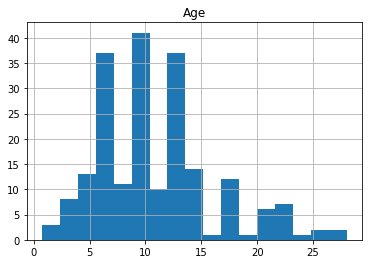

In [19]:
df2.loc[df2['Age'] > 0].hist(column='Age', bins='auto')

I think it's fair to impute all missing values (i.e., 0) with 7. This is based on research, too (Googling and personal knowledge)

In [20]:
df2['Age'] = df2['Age'].replace(0,7)

In [21]:
df2['Age'].describe()

count    585.000000
mean       8.311316
std        3.607727
min        0.750000
25%        7.000000
50%        7.000000
75%        7.000000
max       28.000000
Name: Age, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11a24ab50>]],
      dtype=object)

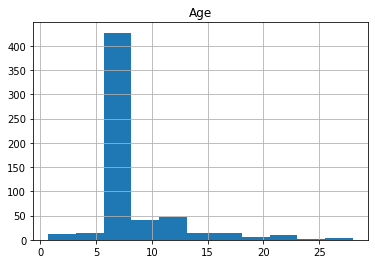

In [22]:
df2.hist(column='Age', bins='auto')

<div class='exercise'>What's the distribution of the <b>"Flavor Summary"</b> feature? Is it consistent enough to use?
</div>

In [23]:
df2['Flavor Summary'].value_counts()

Rich & Full Bodied       54
Sweet & Rich             40
Sweet                    36
Vanilla & Sweet          34
Spicy                    33
Vanilla & Rich           24
Full Bodied & Rich       20
Sweet & Vanilla          20
Spicy & Rich             18
Vanilla                  18
Vanilla & Full Bodied    17
Fruity & Sweet           17
Full Bodied & Spicy      17
Spicy & Vanilla          16
Rich & Vanilla           13
Sweet & Spicy            13
Rich & Spicy             13
Full Bodied              11
Vanilla & Spicy          11
Full Bodied & Vanilla    10
Spicy & Sweet            10
Spicy & Full Bodied      10
Fruity                    9
Rich                      9
Sweet & Full Bodied       9
Rich & Sweet              9
Sweet & Fruity            8
Spicy & Fruity            7
Fruity & Rich             7
Spicy & Smoky             5
Fruity & Spicy            5
Fruity & Vanilla          4
Sweet & Oily              3
Floral & Fruity           3
Floral                    3
Spicy & Herbal      

Ok, there's a long tail of values, and it seems the Flavors are just the two most prominent flavors listed for each whiskey, although some only list one flavor. Perhaps this offers no additional information/signal than using the raw values of the flavors. Although, it might be worth experimenting with this by turning this feature into 2 new features: primary flavor, secondary flavor. These would need to be one-hot encoded though, and since there are 14 distinct flavors, that would create 28 new features (or 26). Again, these 26 features might be redundant and not help our models.

<div class='exercise'>What is the <b>"Badge"</b> feature like?

In [24]:
df2['Badge'].value_counts()

                                            428
RARE                                        119
Requested By\nElw00t                          2
Requested By\njd139                           1
Requested By\ntjbriley                        1
Requested By\nBourbon_Obsessed_Lexington      1
Requested By\nCymru-and-the-Ferg              1
Requested By\ndanmeister33                    1
Requested By\nCblake34                        1
Requested By\ndjriebesell                     1
Requested By\nandrewls24                      1
Requested By\nspectorjuan                     1
Requested By\ncubfancccc                      1
Requested By\nsamueljcarlson                  1
Requested By\nJFForbes                        1
Requested By\nJamesSpears                     1
Requested By\nZonaPT                          1
Requested By\nrsbolen                         1
Requested By\nstevenblackburn7                1
Requested By\nmcoop8                          1
Requested By\nSharksfan321              

We see that all Badge values are either 'RARE' or just requests from users for an expert to review it. So, let's change the badge column to being a 'Rare' column.

In [25]:
df2['Rare'] = [True if x == 'RARE' else False for x in df2['Badge']] #df['Badge'] #.map({"RARE": True})
del df2['Badge']
df2['Rare'].value_counts()

False    466
True     119
Name: Rare, dtype: int64

<div class='exercise'>What is the <b>"Expert"</b> feature like?

In [26]:
df2['Expert'].value_counts()

Jacob Grier          92
Jake Emen            85
Amanda Schuster      76
Stephanie Moreno     66
Rob Morton           62
Keith Allison        26
Colin Howard         23
Sam Davies           21
Nicole Gilbert       17
Distiller Staff      15
Brock Schulte        14
Paul Belbusti        13
Ryan Conklin         12
Jack Robertiello     10
Tim Knittel          10
Katrina Niemisto      8
Dennis Gobis          4
Ron Bechtol           4
Blair Phillips        4
Jason Albaum          3
Matthew Sheinberg     3
Thijs Klaverstijn     3
Derek Gamlin          2
Phil Olson            2
Liza Weisstuch        2
Lucas Gamlin          2
Michael J. Neff       2
Anna Archibald        1
Perri Salka           1
Eric Abert            1
Brad Japhe            1
Name: Expert, dtype: int64

Let's cast our features to the correct data types and view summary statistics

In [27]:
df2 = df2.astype({'Expert Score': 'int32', 'Customers\' Rating' : 'float64', 'ABV %': 'float64'})

In [28]:
df2.describe()

,Age,ABV %,Price,# Ratings,Customers' Rating,Expert Score,Smoky,Peaty,Spicy,Herbal,Oily,Full-bodied,Rich,Sweet,Briny,Salty,Vanilla,Tart,Fruity,Floral
count,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000
mean,8.311316,49.899838,2.803419,416.352137,3.756325,86.447863,21.485470,0.230769,53.726496,25.714530,30.695726,58.447863,57.798291,58.381197,4.018803,5.476923,50.340171,21.548718,37.066667,17.835897
std,3.607727,7.170325,1.055314,1097.906235,0.521737,5.737503,18.322834,2.187232,19.560069,19.547419,22.712536,18.317344,18.361300,16.824334,8.589855,9.603433,20.526266,17.517548,21.334758,20.336899
min,0.750000,40.000000,1.000000,1.000000,1.000000,65.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,45.000000,2.000000,22.000000,3.460000,83.000000,10.000000,0.000000,40.000000,10.000000,10.000000,45.000000,45.000000,50.000000,0.000000,0.000000,35.000000,10.000000,20.000000,0.000000
50%,7.000000,47.500000,3.000000,83.000000,3.780000,87.000000,20.000000,0.000000,55.000000,25.000000,30.000000,60.000000,60.000000,60.000000,0.000000,0.000000,50.000000,20.000000,35.000000,10.000000
75%,7.000000,53.500000,4.000000,238.000000,4.170000,91.000000,30.000000,0.000000,70.000000,40.000000,45.000000,70.000000,70.000000,70.000000,5.000000,10.000000,70.000000,30.000000,50.000000,30.000000
max,28.000000,72.050000,5.000000,9072.000000,4.880000,98.000000,90.000000,40.000000,100.000000,90.000000,100.000000,100.000000,100.000000,99.000000,80.000000,80.000000,100.000000,75.000000,100.000000,95.000000


In [48]:
df2.dtypes

Name                  object
Type                  object
Cask                  object
Location              object
Age                  float64
ABV %                float64
Price                  int64
# Ratings              int64
Customers' Rating    float64
Flavor Summary        object
Expert                object
Expert Score           int32
Smoky                float64
Peaty                float64
Spicy                float64
Herbal               float64
Oily                 float64
Full-bodied          float64
Rich                 float64
Sweet                float64
Briny                float64
Salty                float64
Vanilla              float64
Tart                 float64
Fruity               float64
Floral               float64
Review                object
Rare                    bool
dtype: object

## 4. EDA
Now that our data is cleaned, let's explore it and try to understand any patterns. This understanding will impact our modelling choices. Based on the `.describe()` statistics above, let's first look at the most extreme values of features that seem a bit lopsided in their distribution of values.

<div class='exercise'>Which are the most <b>"Smoky"</b>? Intent is to see if there are any errors or something worth noting.

In [29]:
df2.sort_values(by=['Smoky'], ascending=False)[0:15][['Name', 'Smoky', 'ABV %', 'Price', 'Customers\' Rating', 'Expert Score']]

,Name,Smoky,ABV %,Price,Customers' Rating,Expert Score
0,Cleveland Bourbon,90.0,50.00,2,2.48,70
2055,Warbringer Mesquite Smoked Southwest Bourbon,80.0,49.00,3,4.16,85
1073,"Booker's Bourbon Batch 2019-04 ""Beaten Biscuits""",80.0,63.05,3,4.21,87
1595,Jim Beam Black Label Extra-Aged,80.0,43.00,1,3.28,84
1757,Pappy Van Winkle 23 Year,80.0,47.80,5,4.54,89
1181,Jim Beam Double Oak,75.0,43.00,2,3.21,82
1785,Rebel Yell Kentucky Straight Bourbon 100 Proof,75.0,50.00,1,3.46,86
315,Booker's 25th Anniversary Bourbon,75.0,65.40,4,4.45,96
1640,Elijah Craig Barrel Proof Bourbon,70.0,68.50,4,4.33,93
1447,Garrison Brothers Texas Straight Bourbon,70.0,47.00,4,3.51,84


<div class='exercise'>Which are the most <b>"Peaty"</b>? Intent is to see if there are any errors or something worth noting.

In [30]:
df2.sort_values(by=['Peaty'], ascending=False)[0:10][['Name', 'Peaty', 'ABV %', 'Price', 'Customers\' Rating', 'Expert Score']]

,Name,Peaty,ABV %,Price,Customers' Rating,Expert Score
1529,New Riff Backsetter Peated Backset Bourbon,40.0,50.0,2,3.06,84
1117,Backbone Prime Blended Bourbon,20.0,52.0,2,3.61,82
2055,Warbringer Mesquite Smoked Southwest Bourbon,15.0,49.0,3,4.16,85
562,J. Riddle Peated Bourbon,15.0,45.5,2,3.35,87
171,Evan Williams Single Barrel,10.0,43.3,2,3.87,96
1905,Old Bardstown Black Label Kentucky Straight Bo...,10.0,45.0,1,2.90,86
2179,Knob Creek Small Batch Bourbon,10.0,50.0,2,3.47,84
963,Lux Row Distillers Double Barrel Bourbon 12 Year,5.0,59.2,4,4.03,91
1000,Still & Oak Straight Bourbon,5.0,43.0,2,3.40,83
1240,Angel's Envy Bourbon Finished in Port Wine Bar...,5.0,62.0,5,4.26,92


<div class='exercise'>Which are the least <b>"Spicy"</b>? Intent is to see if there are any errors or something worth noting.

In [31]:
df2.sort_values(by=['Spicy'], ascending=True)[0:14][['Name', 'Spicy', 'ABV %', 'Price', 'Customers\' Rating', 'Expert Score']]

,Name,Spicy,ABV %,Price,Customers' Rating,Expert Score
1031,Dancing Pines Bourbon,0.0,44.00,2,3.09,82
224,Rebel Yell Kentucky Straight Bourbon,0.0,40.00,1,2.88,84
1729,Burnside Oregon Oaked Bourbon,10.0,48.00,2,3.43,84
618,Three Chord Blended Bourbon,10.0,40.50,2,3.10,72
681,Old Charter 8 Year,10.0,40.00,1,2.88,80
1381,Rough Rider Straight Bourbon,15.0,45.00,2,3.34,85
939,TX Straight Bourbon Whiskey,15.0,47.00,4,3.47,84
1778,Orange County Distillery Bourbon,15.0,45.00,3,3.38,79
671,County Seat Spirits Hidden Copper Bourbon,15.0,45.00,2,3.50,80
1991,Black Maple Hill 16 Year Bourbon,15.0,47.50,4,4.62,97


<div class='exercise'>Which are the most <b>"Herbal"</b>? Intent is to see if there are any errors or something worth noting.

In [32]:
df2.sort_values(by=['Herbal'], ascending=False)[0:20][['Name', 'Herbal', 'ABV %', 'Price', 'Customers\' Rating', 'Expert Score']]

,Name,Herbal,ABV %,Price,Customers' Rating,Expert Score
592,Remus Volstead Reserve 14 Year Bottled in Bond...,90.0,50.0,5,4.25,89
1349,Temperance Trader Chinato Barrel-Finished Bourbon,90.0,45.0,2,3.61,87
1503,Redemption High Rye Bourbon,82.0,46.0,2,3.35,82
1851,Elijah Craig Barrel Proof Bourbon Batch C919,80.0,68.4,3,4.33,91
865,Treaty Oak Red Handed Bourbon (Kentucky & Virg...,80.0,47.5,2,3.68,83
373,Belle Meade Cask Strength Single Barrel Bourbo...,80.0,61.2,3,4.37,95
623,Cody Road Bourbon,78.0,45.0,2,2.72,71
895,Evan Williams White Label Bottled in Bond Bourbon,76.0,50.0,1,3.35,80
1830,Black Button Four Grain Bourbon,75.0,42.0,2,3.31,87
1442,Yellowstone Kentucky Straight Bourbon 9 Year (...,75.0,50.5,4,4.08,88


<div class='exercise'>Which are the most <b>"Oily"</b>? Intent is to see if there are any errors or something worth noting.

In [33]:
df2.sort_values(by=['Oily'], ascending=False)[0:15][['Name', 'Oily', 'ABV %', 'Price', 'Customers\' Rating', 'Expert Score']]

,Name,Oily,ABV %,Price,Customers' Rating,Expert Score
1757,Pappy Van Winkle 23 Year,100.0,47.80,5,4.54,89
1640,Elijah Craig Barrel Proof Bourbon,100.0,68.50,4,4.33,93
1442,Yellowstone Kentucky Straight Bourbon 9 Year (...,95.0,50.50,4,4.08,88
1851,Elijah Craig Barrel Proof Bourbon Batch C919,90.0,68.40,3,4.33,91
514,Parker's Heritage Cognac Barrel Finish 10 Year...,90.0,50.00,3,4.53,96
303,George T. Stagg Bourbon (Fall 2013),90.0,64.10,5,4.62,97
865,Treaty Oak Red Handed Bourbon (Kentucky & Virg...,90.0,47.50,2,3.68,83
1182,Barrell Bourbon Batch 008,85.0,66.40,4,4.20,83
916,Four Roses Limited Edition Single Barrel Bourb...,80.0,54.20,4,4.25,98
1785,Rebel Yell Kentucky Straight Bourbon 100 Proof,80.0,50.00,1,3.46,86


<div class='exercise'>Which are the least <b>"Full-bodied"</b>? Intent is to see if there are any errors or something worth noting.

In [34]:
df2.sort_values(by=['Full-bodied'], ascending=True)[0:20][['Name', 'Full-bodied', 'ABV %', 'Price', 'Customers\' Rating', 'Expert Score']]

,Name,Full-bodied,ABV %,Price,Customers' Rating,Expert Score
618,Three Chord Blended Bourbon,5.0,40.50,2,3.10,72
0,Cleveland Bourbon,10.0,50.00,2,2.48,70
1031,Dancing Pines Bourbon,10.0,44.00,2,3.09,82
1641,291 Colorado Bourbon,15.0,50.00,3,3.60,78
2027,Feisty Spirits Blue Corn Bourbon,15.0,44.00,2,2.50,81
496,Bird Dog Small Batch Bourbon,15.0,43.00,2,3.14,82
2063,Ancient Age,20.0,40.00,1,2.55,78
1218,Burnside Bourbon,20.0,48.00,2,3.14,79
658,Maryland Club Straight Bourbon,20.0,47.50,2,2.00,78
1391,Central Standard Bourbon,20.0,45.00,2,2.42,80


<div class='exercise'>Which are the most <b>"Briny"</b>? Intent is to see if there are any errors or something worth noting.

In [35]:
df2.sort_values(by=['Briny'], ascending=False)[0:20][['Name', 'Briny', 'ABV %', 'Price', 'Customers\' Rating', 'Expert Score']]

,Name,Briny,ABV %,Price,Customers' Rating,Expert Score
1524,Treaty Oak Ghost Hill Texas Bourbon,80.0,47.50,2,3.50,80
1834,Elijah Craig 12 Year,60.0,47.00,2,3.80,93
1481,Jefferson's Ocean Aged at Sea Voyage 15 Specia...,50.0,45.00,4,3.87,82
527,Old Soul Blended Straight Bourbon,45.0,45.00,2,3.49,74
1882,Pappy Van Winkle Family Reserve 15 Year,40.0,53.50,4,4.53,89
224,Rebel Yell Kentucky Straight Bourbon,40.0,40.00,1,2.88,84
623,Cody Road Bourbon,40.0,45.00,2,2.72,71
1149,Murray Hill Club Blended Bourbon,40.0,51.00,4,3.49,82
1757,Pappy Van Winkle 23 Year,30.0,47.80,5,4.54,89
1447,Garrison Brothers Texas Straight Bourbon,30.0,47.00,4,3.51,84


<div class='exercise'>Which are the most <b>"Salty"</b>? Intent is to see if there are any errors or something worth noting.

In [36]:
df2.sort_values(by=['Salty'], ascending=False)[0:20][['Name', 'Salty', 'ABV %', 'Price', 'Customers\' Rating', 'Expert Score']]

,Name,Salty,ABV %,Price,Customers' Rating,Expert Score
1524,Treaty Oak Ghost Hill Texas Bourbon,80.0,47.50,2,3.50,80
1864,Blaum Bros. Galena Reserve (Series 0),55.0,57.80,3,4.50,86
207,Remus Repeal Reserve Series III Straight Bourbon,55.0,50.00,4,3.88,86
1481,Jefferson's Ocean Aged at Sea Voyage 15 Specia...,50.0,45.00,4,3.87,82
1834,Elijah Craig 12 Year,50.0,47.00,2,3.80,93
162,"Booker's Bourbon Batch 2020-01 ""Granny's Batch""",40.0,63.20,4,4.07,92
1837,Coppersea Excelsior Bourbon,40.0,48.00,4,2.88,81
1785,Rebel Yell Kentucky Straight Bourbon 100 Proof,40.0,50.00,1,3.46,86
1757,Pappy Van Winkle 23 Year,40.0,47.80,5,4.54,89
1882,Pappy Van Winkle Family Reserve 15 Year,40.0,53.50,4,4.53,89


<div class='exercise'>Which are the most <b>"Tart"</b>? Intent is to see if there are any errors or something worth noting.

In [37]:
df2.sort_values(by=['Tart'], ascending=False)[0:20][['Name', 'Tart', 'ABV %', 'Price', 'Customers\' Rating', 'Expert Score']]

,Name,Tart,ABV %,Price,Customers' Rating,Expert Score
592,Remus Volstead Reserve 14 Year Bottled in Bond...,75.0,50.00,5,4.25,89
1925,Redemption Temptation Bourbon,74.0,41.00,2,2.91,77
895,Evan Williams White Label Bottled in Bond Bourbon,72.0,50.00,1,3.35,80
1524,Treaty Oak Ghost Hill Texas Bourbon,70.0,47.50,2,3.50,80
1768,Peach Street Colorado Straight Bourbon,70.0,46.00,3,3.59,83
782,Johnny Drum Green Label Bourbon,70.0,40.00,2,3.19,82
1933,Elijah Craig Single Barrel 21 Year,69.0,45.00,5,4.14,87
1371,Rock Hill Farms Bourbon,68.0,50.00,3,4.19,91
865,Treaty Oak Red Handed Bourbon (Kentucky & Virg...,65.0,47.50,2,3.68,83
176,Oola Waitsburg Bourbon,65.0,47.00,2,3.37,80


<div class='exercise'>Which are the most <b>"Fruity"</b>? Intent is to see if there are any errors or something worth noting.

In [38]:
df2.sort_values(by=['Fruity'], ascending=False)[0:20][['Name', 'Fruity', 'ABV %', 'Price', 'Customers\' Rating', 'Expert Score']]

,Name,Fruity,ABV %,Price,Customers' Rating,Expert Score
325,Heaven Hill Select Stock Bourbon,100.0,65.10,4,4.09,84
2195,Barrell Bourbon Batch 007,90.0,61.20,3,3.50,83
448,Buffalo Trace Experimental Collection French O...,90.0,45.00,4,3.35,88
453,W.H. Harrison Governor's Reserve Bourbon,90.0,56.50,3,3.36,84
1056,Parker's Heritage Master Distiller's Blend of ...,90.0,63.50,3,4.18,93
1980,1792 High Rye Bourbon,90.0,47.15,2,3.72,85
1727,Four Roses Limited Edition Small Batch Bourbon...,90.0,53.65,4,4.28,92
1525,Blaum Bros Knotter Bourbon 3 Year (Batch #6),85.0,45.00,2,3.49,76
1959,Woodford Reserve Master’s Collection Brandy Ca...,85.0,45.20,4,4.17,91
895,Evan Williams White Label Bottled in Bond Bourbon,81.0,50.00,1,3.35,80


<div class='exercise'>Which are the <b>oldest?</b> Intent is to see if there are any errors or something worth noting.

In [39]:
df2.sort_values(by=['Age'], ascending=False)[0:20][['Name', 'Age', 'ABV %', 'Price', 'Customers\' Rating', 'Expert Score']]

,Name,Age,ABV %,Price,Customers' Rating,Expert Score
1833,Hirsch Selection 28 Year Bourbon,28.0,43.40,5,3.89,97
702,Heaven Hill 27 Year Barrel Proof Kentucky Stra...,27.0,47.35,5,4.26,93
1621,Old Blowhard 26 Year Bourbon,26.0,45.35,5,3.68,81
1193,Michter's 25 Year Single Barrel Bourbon,25.0,54.30,5,4.49,87
1348,Rhetoric 24 Year Bourbon,24.0,45.40,4,4.21,89
1757,Pappy Van Winkle 23 Year,23.0,47.80,5,4.54,89
437,Rhetoric 23 Year Bourbon,23.0,45.30,4,4.21,85
2020,Evan Williams 23 Year Bourbon,23.0,53.50,5,4.37,86
754,Elijah Craig 23 Year Bourbon,23.0,45.00,5,4.19,90
140,Blade And Bow Bourbon 22 Year (2015 Release),22.0,46.00,5,4.29,87


<div class='exercise'>Which are the most <b>popular</b>? Intent is to see if there are any errors or something worth noting.

In [40]:
df2.sort_values(by=['# Ratings'], ascending=False)[0:20][['Name', '# Ratings', 'Rare', 'ABV %', 'Price', 'Customers\' Rating', 'Expert Score']]

,Name,# Ratings,Rare,ABV %,Price,Customers' Rating,Expert Score
276,Blanton's Original Single Barrel,9072,False,46.5,2,4.30,89
826,Buffalo Trace Bourbon,8913,False,45.0,2,3.66,83
917,Eagle Rare 10 Year Bourbon,8656,False,45.0,2,4.02,91
113,Maker's Mark Bourbon,7209,False,45.0,2,3.46,87
85,Woodford Reserve Bourbon,7087,False,45.2,2,3.65,85
1744,Bulleit Bourbon,6712,False,45.0,2,3.48,86
1909,Four Roses Single Barrel Bourbon,5890,False,50.0,2,4.00,90
465,Basil Hayden's Bourbon,5328,False,40.0,2,3.62,80
1133,Weller Special Reserve,4931,False,45.0,2,3.89,91
285,Angel's Envy Bourbon Finished in Port Wine Bar...,4741,False,43.3,2,3.86,84


Ah, interestingly, the single-most popular, `Blanton's` is actually **very** hard to find these days. The field wrongly states it's not rare, but it is essentially impossible to find in most US States, and bottles are commonly marked up from $40 MSRP to $200. I'm very surprised that this has the most reviews, but I suspect it's because it has the highest allure amongst the rare ones that are somewhat possible to find. Years ago, it was very easy to find, so maybe some reviews were from this time.

Additionally, `Weller Special Reserve` is also impossible to get within most places in the US, for most times of the year, but it has TONS of allure and attention. People obsess over it. `Weller Antique 107` is even rarer. The rest are very common within stores and bars, so the data makes sense for these.

<div class='exercise'>Which are the best according to <b>customers</b>? Intent is to see if there are any errors or something worth noting.

In [41]:
df2.sort_values(by=["Customers\' Rating"], ascending=False)[0:20][['Name', '# Ratings', 'ABV %', 'Price', 'Customers\' Rating', 'Expert Score']]

,Name,# Ratings,ABV %,Price,Customers' Rating,Expert Score
1936,Parker's Heritage Heavy Char Bourbon 10 Year,2,60.00,4,4.88,92
1283,Abraham Bowman Sweet XVI Bourbon,15,58.00,3,4.84,93
871,William Larue Weller Bourbon (Fall 2020),1,67.25,4,4.75,93
2078,William Larue Weller Bourbon (Fall 2016),134,67.70,4,4.71,96
1570,William Larue Weller Bourbon (Fall 2017),182,64.10,4,4.71,90
593,William Larue Weller Bourbon (Fall 2015),232,67.30,3,4.70,98
1463,King of Kentucky 15 Year Kentucky Straight Bou...,23,65.50,5,4.69,90
296,Old Forester President's Choice Bourbon,3,59.30,5,4.67,90
21,Four Roses Limited Edition 50th Anniversary Sm...,158,54.30,4,4.67,94
1317,Pappy Van Winkle 20 Year,893,45.20,4,4.67,92


This seems correct to me, not because I've tasted any of these, but because these are famous and are highly coveted. I've never heard of the best rated, `Parker's`, though. I'd be suspicious that it's an outlier and wrong, especially considering it only has 2 reviews from users; however, the expert also gave it a high score, so it seems like a valid entry.

In [42]:
df2.sort_values(by=["Customers\' Rating"], ascending=True)[0:20][['Name', '# Ratings', 'ABV %', 'Price', 'Customers\' Rating', 'Expert Score']]

,Name,# Ratings,ABV %,Price,Customers' Rating,Expert Score
486,Double Diamond Limited Edition Bourbon 267,1,40.0,2,1.00,80
2167,Syntax Spirits Bourbon,2,47.5,2,2.00,80
658,Maryland Club Straight Bourbon,2,47.5,2,2.00,78
1920,"Winchester ""Extra Smooth"" Bourbon",75,45.0,1,2.21,65
1108,Detroit City Two-Faced Bourbon,8,47.0,2,2.25,77
1244,Black Button Little Barrel Bourbon,8,42.0,3,2.38,75
230,Adirondack 601 Bourbon,21,43.2,3,2.40,78
1250,Old Crow Kentucky Straight Bourbon,197,40.0,1,2.40,71
1391,Central Standard Bourbon,9,45.0,2,2.42,80
801,Evan Williams Green Label,177,40.0,1,2.45,81


I've never heard of any of these, so this list seems reasonable. Plus, the experts gave them all horrible reviews, so I don't suspect anything suspicious is going on (e.g., customers ironically rating a controversial, highly-appraised whiskey as being horribly low, as if to troll the ratings).

<div class='exercise'>Which are the best according to <b>experts</b>? Intent is to see if there are any errors or something worth noting.

In [43]:
df2.sort_values(by=['Expert Score'], ascending=False)[0:20][['Name', '# Ratings', 'ABV %', 'Price', 'Customers\' Rating', 'Expert Score']]

,Name,# Ratings,ABV %,Price,Customers' Rating,Expert Score
12,"Booker's Bourbon Batch 2015-01 ""Big Man, Small...",698,64.35,3,4.38,98
1635,Four Roses Limited Edition Single Barrel Bourb...,158,59.80,5,4.23,98
1575,George T. Stagg Bourbon (Fall 2019),395,58.45,4,4.59,98
593,William Larue Weller Bourbon (Fall 2015),232,67.30,3,4.70,98
916,Four Roses Limited Edition Single Barrel Bourb...,503,54.20,4,4.25,98
1917,Parker's Heritage Promise of Hope,224,48.00,4,4.45,98
303,George T. Stagg Bourbon (Fall 2013),422,64.10,5,4.62,97
1671,Wild Turkey Diamond Anniversary Bourbon,278,45.50,4,4.33,97
1991,Black Maple Hill 16 Year Bourbon,69,47.50,4,4.62,97
1833,Hirsch Selection 28 Year Bourbon,11,43.40,5,3.89,97


This seems right. Never heard of `Hirsch` or `Parker's` but the others are speciality versions of famous/popular whiskeys, so this makes sense.

<div class='exercise'>Which are the most <b>expensive</b>? Intent is to see if there are any errors or something worth noting.

In [44]:
df2.sort_values(by=['Price'], ascending=False)[0:15][['Name', '# Ratings', 'ABV %', 'Price', 'Customers\' Rating', 'Expert Score']]

,Name,# Ratings,ABV %,Price,Customers' Rating,Expert Score
592,Remus Volstead Reserve 14 Year Bottled in Bond...,31,50.00,5,4.25,89
1649,Angel's Envy Bourbon Finished in Mizunara Oak,3,48.90,5,3.58,91
702,Heaven Hill 27 Year Barrel Proof Kentucky Stra...,28,47.35,5,4.26,93
140,Blade And Bow Bourbon 22 Year (2015 Release),56,46.00,5,4.29,87
303,George T. Stagg Bourbon (Fall 2013),422,64.10,5,4.62,97
1779,Russell's Reserve 2002,30,57.30,5,4.43,95
296,Old Forester President's Choice Bourbon,3,59.30,5,4.67,90
2108,King of Kentucky 14 Year Kentucky Straight Bou...,23,67.50,5,4.61,94
2020,Evan Williams 23 Year Bourbon,35,53.50,5,4.37,86
1511,Michter's 20 Year Single Barrel Bourbon,110,57.10,5,4.49,94


We don't have high granularity (prices are just 1-5), which is perhaps a blessing in disguise -- most bourbons are \\$30 - \\$50, but some rare ones, especially due to price gouging, can be \\$100 - \\$3,000. That's a wild range and is largely due to rarity, allure, and sensationalism within human behavior, as opposed to actual qualities of the bourbon. So, maybe it's good that we don't have to deal with outlier whiskeys have extraordinary prices.

<div class='exercise'>Where do they come from? Intent is to see if there are any errors or something worth noting.

In [45]:
df2['Location'].value_counts()

Booker's // Kentucky, USA                                                                 22
Four Roses // Kentucky, USA                                                               18
Buffalo Trace // Kentucky, USA                                                            16
Old Forester // Kentucky, USA                                                             16
Jim Beam // Kentucky, USA                                                                 15
Heaven Hill // Kentucky, USA                                                              14
Elijah Craig // Kentucky, USA                                                             13
Woodford Reserve // Kentucky, USA                                                         12
Wild Turkey // Kentucky, USA                                                              10
Barton 1792 // Kentucky, USA                                                               7
Knob Creek // Kentucky, USA                                           

Some distilleries produce different brands of whiskey. Most come from Kentucky. You can see that some distilleries produce tons of different types, but this can be a bit misleading because some of those different types are just slight variations (e.g., Eagle Rare 10, Eagle Rare 17), whereas others are completely different brands (e.g., Buffalo Trace, Blanton's). For now, it's probably best to just ignore the `location` feature, but we'll keep it in mind for modelling, if we get desperate. One idea would be to create 2 fields from this: 1 for the geographic state (e.g., Kentucky), and another for the distillery (e.g., Booker's).

<div class='exercise'>Let's look at the distribution of <b>flavor</b> values? Intent is to see if there are any errors or something worth noting.

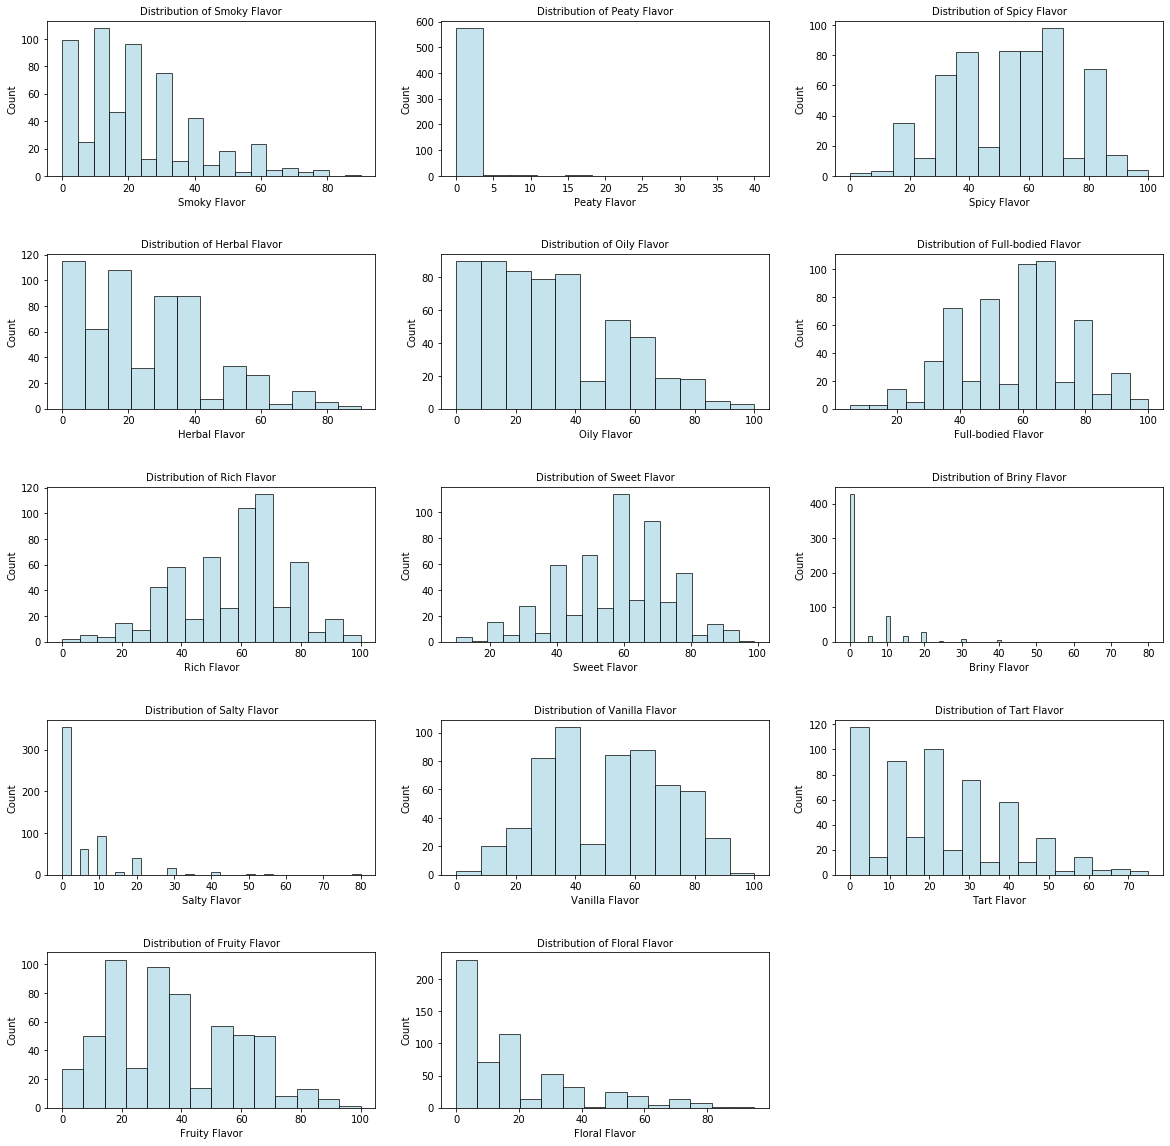

In [46]:
fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(20, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.2)
axs = axs.ravel()
fontsize = 10

flavors = ['Smoky', 'Peaty', 'Spicy', 'Herbal', 'Oily', 'Full-bodied', 'Rich',\
        'Sweet', 'Briny', 'Salty', 'Vanilla', 'Tart', 'Fruity', 'Floral']

# plot histograms
for i, flavor in enumerate(flavors):
    axs[i].hist(df2[flavor], alpha=0.7, color='lightblue', bins='auto', density=False, histtype = 'bar', edgecolor='k')
    axs[i].set_title("Distribution of " + flavor + " Flavor", fontsize=fontsize)
    axs[i].set_xlabel(flavor + " Flavor", fontsize=fontsize)
    axs[i].set_ylabel('Count', fontsize=fontsize)
    
# removes the empty one, since we only have 14 flavors, not 15
axs[14].set_axis_off()

These all seem pretty reasonable, and I'm glad that the values have a good spread. A few flavors are a bit skewed, and these are the ones that we inspected above.

<div class='exercise'>Let's look for any patterns/correlations that may exists between our features. Since some of the above flavors are skewed (e.g., `Salty` is usually 0), we would not be able to discern any meaningful trend, so we can throw this out from our visualization. Otherwise, our graph woud just be a bunch of points overlapping one another at the 0 value.

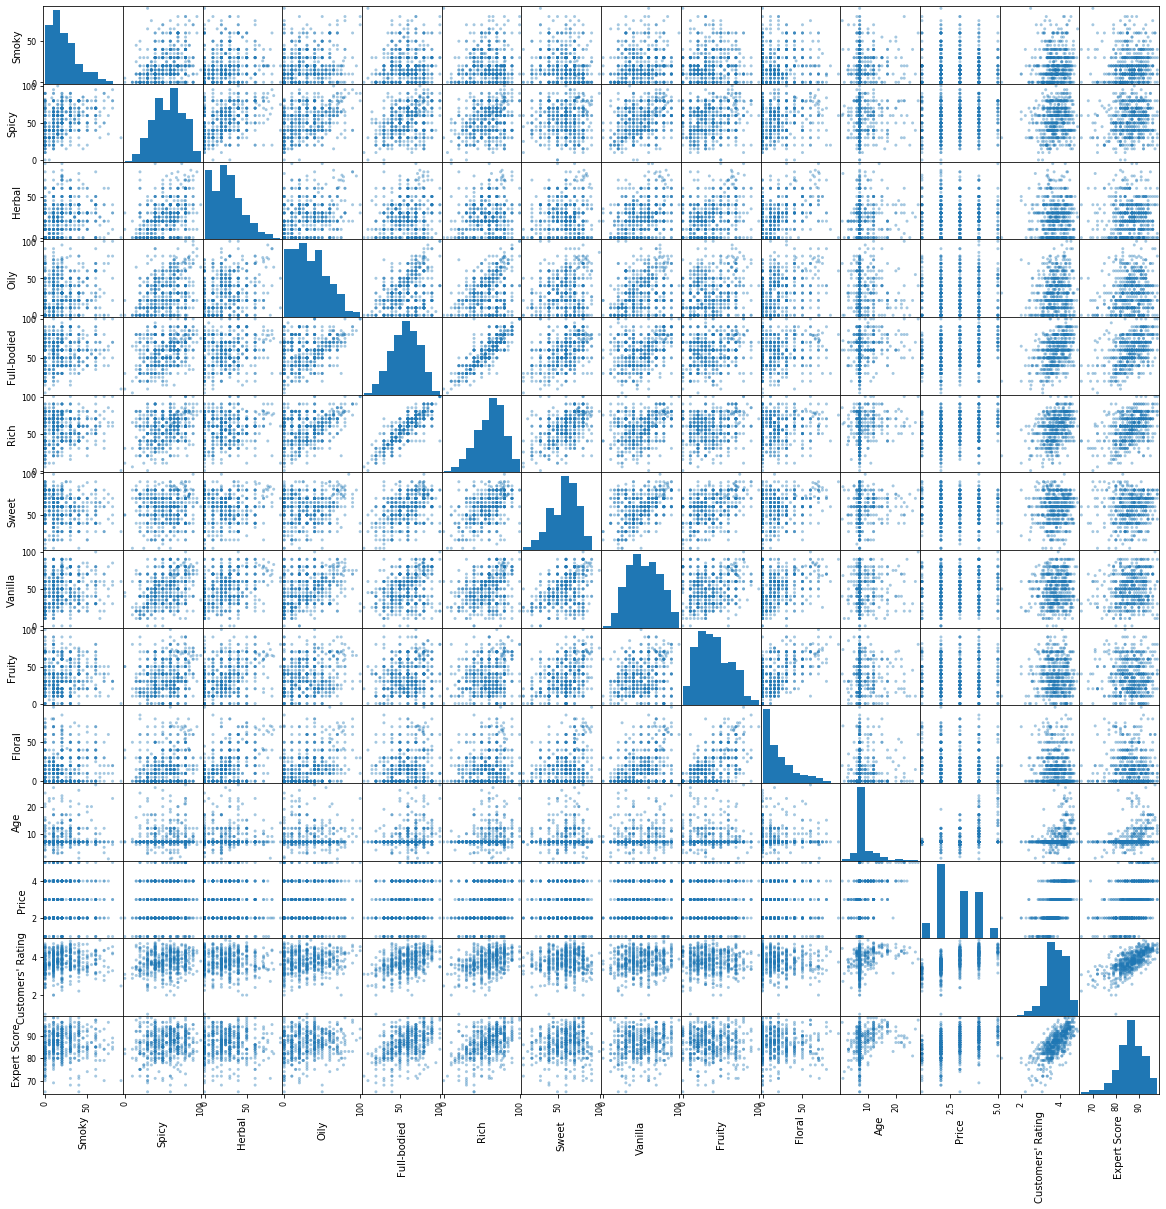

In [47]:
grid_features = ['Smoky', 'Spicy', 'Herbal', 'Oily', 'Full-bodied', 'Rich',\
        'Sweet', 'Vanilla', 'Fruity', 'Floral', \
        'Age', 'Price', 'Customers\' Rating', 'Expert Score']

scatter = pd.plotting.scatter_matrix(df2[grid_features], alpha=0.4, figsize=(20,20));
for ax in scatter.ravel():
    ax.set_xlabel(ax.get_xlabel(), rotation = 90)
    ax.set_ylabel(ax.get_ylabel(), rotation = 90)

We see that:
- `Customer's Rating` is highly correlated with the expert's rating
- The higher the `Price`, the more likely it is to have a high score from both customers and experts
- The higher the `Richness`, the more `Full-bodied` and `Sweet` it tends to be (strong correlations)
- The higher the `Oiliness`, the more likely it is to be `Full-bodied`
- No individual flavor seems correlated with the scores from customers or experts. The closest trend is from `Full-bodied` and `Rich`, as they seem slightly directly correlated with the scores.

This is an indication that predicting the score is not trivially easy; the `Full-bodied` and `Richness` can play some role, but if flavors give any indication, it'll be due to a combination of flavors instead of any one particular flavor.